# Loading Text, Chunking, Embedding and Upserting into Pinecone Index

### 1. Load Text

In [1]:
doc_path = (r"hr_policy.txt")

# Open the file
with open(doc_path, 'r') as f:
    # Read the file
    contents = f.read()

In [2]:
# set up tokenizer
import tiktoken
tokenizer = tiktoken.get_encoding('p50k_base')


# create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(
        text,
        disallowed_special=()
    )
    return len(tokens)

# sample
tiktoken_len("hello I am a chunk of text and using the tiktoken_len function "
             "we can find the length of this chunk of text in tokens")

28

### 2. Create chunking function

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=20,
    length_function=tiktoken_len,
    separators=["\n\n", "\n", " ", ""]
)

chunks = text_splitter.split_text(contents)
chunks[0]

'HR POLICY MANUAL - LEAVE POLICY\nI. PURPOSE\nThis policy is designed to provide a clear and consistent understanding of the leave benefits provided by our company to its employees. It covers the rules and regulations regarding Vacation Leave, Sick Leave, and Service Incentive Leave.\nII. SCOPE\nThis policy applies to all regular full-time employees of the company, regardless of their position or department.\nIII. LEAVE POLICY\nA. Vacation Leave\n1.\tEligibility and Accrual: All regular full-time employees are eligible for Vacation Leave. Employees will earn 1.25 days of Vacation Leave per month of service, accruing to 15 days per year.\n2.\tApplication: Leave applications must be submitted through the Employee Self Service portal at least one day before the intended leave date. Approval from the immediate supervisor is required.\n3.\tUnused Leave: Unused Vacation Leave can be carried over to the next year. However, the total accumulated leave should not exceed 30 days. Any excess leav

### 3. Create Embeddings

In [4]:
# initialize embedding function
from langchain.embeddings.openai import OpenAIEmbeddings
import os

OPENAI_API_KEY = "<your openai api key from platform.openai.com>" # there is a free tier. still trying to figure out how to use the azure deployment instead

model_name = 'text-embedding-ada-002'

# set embeddings function
embed = OpenAIEmbeddings(
    model = model_name,
    openai_api_key=OPENAI_API_KEY
)

In [ ]:
# create data format from chunked text for upserting into Pinecone index. Format: id, embeddings, metadata
from uuid import uuid4

vectors = [(str(uuid4()), embed.embed_documents([text])[0], {"text": text}) for text in chunks]


#### How the 'vectors' or embeddings look when printed. 
There are 1536 elements to the vector representing each chunk of data.

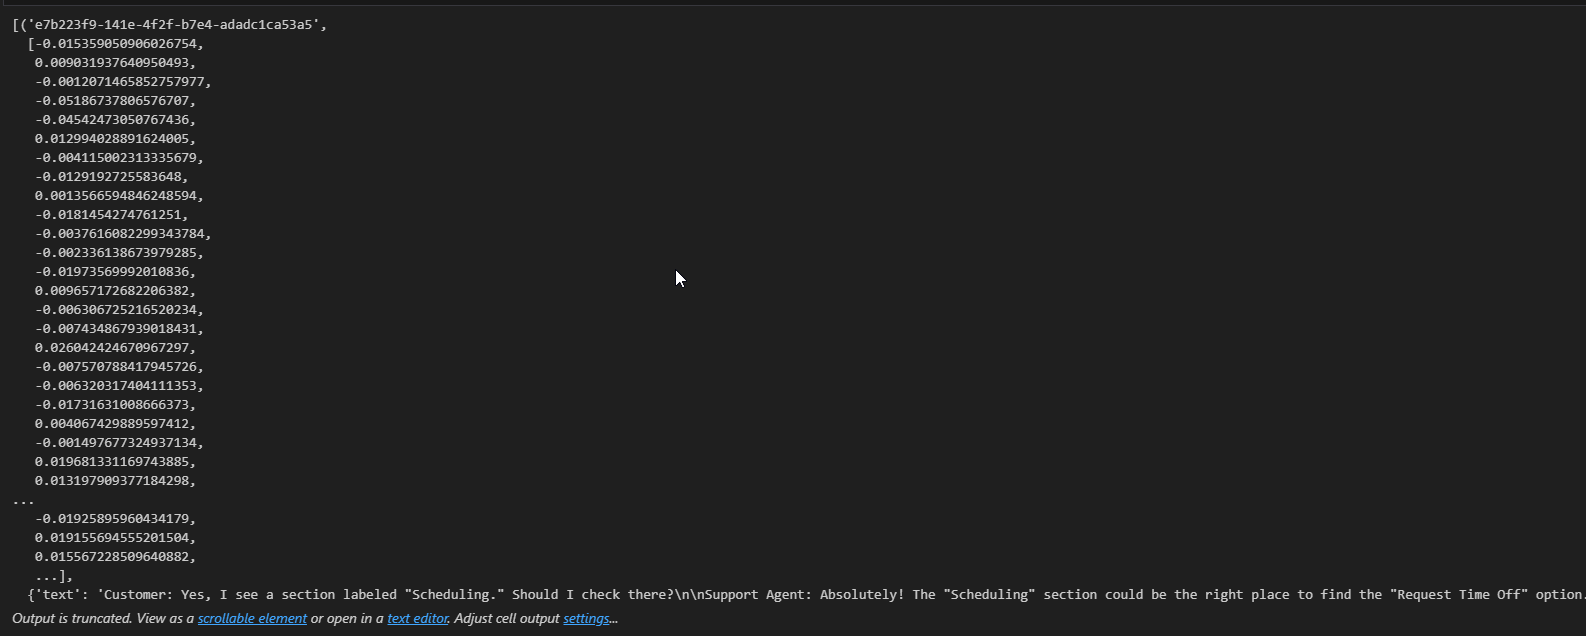

### 4. Prep Pinecone Index

In [7]:
import pinecone

index_name = 'tk-policy'
dimension=1536

pinecone.init(
        api_key="<your pineceone api key>",  # get yours from pinecone.io. there is a free tier.
        environment="<your pinecone environment>"  
)

# delete index if it exists
if index_name in pinecone.list_indexes():
    pinecone.delete_index(index_name)

# create index
pinecone.create_index(
        name=index_name,
        metric='cosine',
        dimension=dimension       
)

/home/stepanogil/ChatBotDev/.venv/lib/python3.10/site-packages/pinecone/index.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### 5. Upsert vectors to index

In [9]:
# connect to index
index = pinecone.Index(index_name)

# upsert vectors to pinecone
index.upsert(
    vectors=vectors,
    #namespace=index_name, 
    values=True, 
    include_metadata=True
    )

index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 16}},
 'total_vector_count': 16}